<h1> Segmentation Model

#### _Installs, imports and paths_

In [2]:
# Installations
# pip install --upgrade tensorflow
# pip install tensorflow-addons
# pip install tensorflow-datasets
# pip install opencv-python

In [1]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing import image

2023-01-06 11:31:32.595969: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
path_img = '../data/images'
path_img_masks = '../data/masks'
notebooks_asb_path = '/Users/camilleepitalon/Documents/DSB/hec/17_mckinsey_tech_challenge/mcksy-challenge-geosilos/notebooks'

## Load data

In [2]:
info_df = pd.read_csv('../data/x-ai_data.csv')

train_df = info_df[info_df['split']=='train'].reset_index()
validation_df = info_df[info_df['split']=='validation'].reset_index()

train_df.drop(['split', 'index'], axis=1, inplace=True)
validation_df.drop(['split', 'index'], axis=1, inplace=True)

In [12]:
os.chdir(notebooks_asb_path)

image_list = os.listdir(path_img)
mask_list = os.listdir(path_img_masks)

def data_loader(dataframe, file_names, val=False): 
    # create a deeplearning-ready dataset from a given dataframe and image names 
    image_names = [name for name in file_names if name in list(dataframe.filename)]
    return create_dataset(image_names, val)

def create_dataset(image_names, val=False): 
    # load the images and store them as a tensor
    if val: 
        data_images = tf.zeros([0, 256, 256, 1], tf.float32)
    else:
        data_images = tf.zeros([0, 256, 256, 3], tf.float32) 
    for i in range(len(image_names)): 
        image = load_image(image_names[i], val)
        if val: 
            image = tf.expand_dims(image, axis=-1)
        data_images = tf.concat([data_images, image], axis=0)
        image = rotate_image(image)
        data_images = tf.concat([data_images, image], axis=0)
    return data_images

def load_image(image_name, val=False): 
    # reads image and returns the desired shape tensor
    image = cv2.imread(image_name)
    if val:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = tf.convert_to_tensor(image/255.0, tf.float32)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = tf.convert_to_tensor(image/255.0, tf.float32)
    image = tf.expand_dims(image, axis=0)
    return image

def rotate_image(image): 
    return tf.image.rot90(image)

os.chdir(path_img)
X_train, X_val = data_loader(train_df, image_list), data_loader(validation_df, image_list)
os.chdir('../masks')
Y_train, Y_val = data_loader(train_df, image_list, val=True), data_loader(validation_df, image_list, val=True)

os.chdir(notebooks_asb_path)

## Build Model

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose
from keras.layers import Activation, Dropout, Flatten, Dense, concatenate

In [14]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):

    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(conv)
    conv = BatchNormalization()(conv, training=False)
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv
    skip_connection = conv
    
    return next_layer, skip_connection

In [15]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):

    up = Conv2DTranspose(n_filters, (3,3), strides=(2,2), padding='same')(prev_layer_input)
    merge = concatenate([up, skip_layer_input], axis=3)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(conv)
    
    return conv

In [16]:
def unet_model(input_shape=(256, 256, 3), n_filters=32, n_classes=1):
    
    inputs = tf.keras.Input(shape=input_shape)
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [17]:
model = unet_model(input_shape=(256,256,3), n_filters=32, n_classes=1)
model.compile(optimizer=tf.keras.optimizers.Adam(), 
             # loss=tfa.losses.SigmoidFocalCrossEntropy(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=tf.keras.metrics.RootMeanSquaredError())

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [19]:
results = model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
79/79 [==============================] - 1015s 13s/step - loss: 1.3825 - root_mean_squared_error: 1.1758 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199
Epoch 2/10
79/79 [==============================] - 998s 13s/step - loss: 0.0105 - root_mean_squared_error: 0.1025 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 3/10
79/79 [==============================] - 1073s 14s/step - loss: 0.0104 - root_mean_squared_error: 0.1018 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1171
Epoch 4/10
79/79 [==============================] - 1045s 13s/step - loss: 0.0100 - root_mean_squared_error: 0.1002 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 5/10
79/79 [==============================] - 1075s 14s/step - loss: 0.0099 - root_mean_squared_error: 0.0995 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154
Epoch 6/10
79/79 [==============================] - 1030s 13s/step - loss: 0.0101 - root_mean_squared_error: 0.1004 - val_loss: 0.0136 -

In [20]:
predictions = model.predict(X_val)

25/25 [==============================] - 80s 3s/step


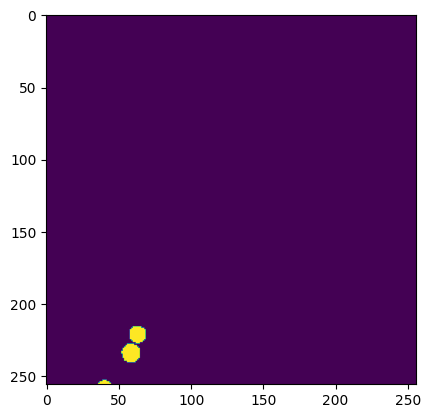

In [29]:
plt.imshow(Y_val[5])

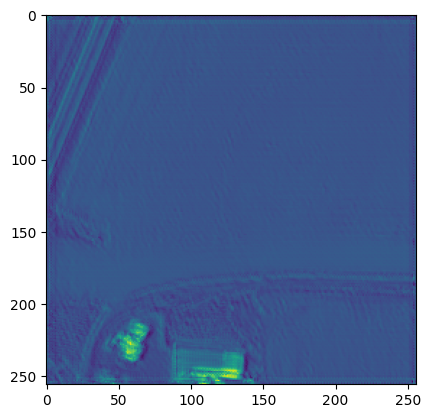

In [30]:
plt.imshow(predictions[5])

In [45]:
predictions2 = tf.where(predictions < 0.05, 0, 1)

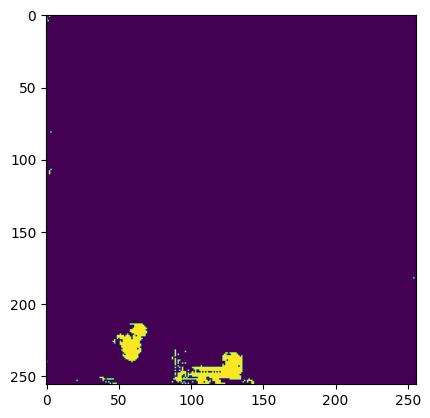

In [46]:
plt.imshow(predictions2[5])

## This is not important

In [ ]:
import tensorflow.keras.initializers as initializers
import tensorflow.keras.regularizers as regularizers
import tensorflow.keras.layers as layers

In [ ]:
def build_convBlock(input_data, num_filters, kernel_x, kernel_y, stride_x, stride_y, batch_normalization=True, padding="VALID"): 
  
    kernel_initializer = initializers.TruncatedNormal(stddev=0.02/3/3/1)
    kernel_regularizer = regularizers.l2(0.01)
    bias_initalizer = initializers.Constant(0.0)
    bias_regularizer = regularizers.l2(0.01)
  
    output_data = tf.pad(input_data, [[0, 0], [kernel_x//2, kernel_x//2], [kernel_x//2, kernel_x//2], [0, 0]], mode="CONSTANT")
    output_data = layers.Conv2D(num_filters, kernel_size=(kernel_x, kernel_y), activation=None, padding='VALID', strides=(stride_x, stride_y), kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer, bias_initializer=bias_initalizer, bias_regularizer=bias_regularizer)(output_data)
    if batch_normalization: 
        output_data = layers.BatchNormalization(momentum=0.99, center=True, scale=True)(output_data)
    output_data = tf.keras.layers.ReLU()(output_data) # RELU
  
    return output_data

In [ ]:
def build_residualBlock(input_data, num_filters, use_bias=True, downsample=False):  

    output_data = layers.BatchNormalization(momentum=0.99, epsilon=1e-05, center=True, scale=True)(input_data)
    output_data = tf.keras.layers.ReLU()(output_data) # layers.ReLU
    if downsample: 
        output_data = layers.Conv2D(num_filters, kernel_size=(3, 3), activation=None, padding='SAME', strides=(2, 2), kernel_initializer=initializers.VarianceScaling(), kernel_regularizer=regularizers.l2(0.01), use_bias=True)(output_data)
        input_data = layers.Conv2D(num_filters, kernel_size=(1, 1), activation=None, padding='SAME', strides=(2, 2), kernel_initializer=initializers.VarianceScaling(), kernel_regularizer=regularizers.l2(0.01), use_bias=True)(input_data)
    else:
        output_data = layers.Conv2D(num_filters, kernel_size=(3, 3), activation=None, padding='SAME', strides=(1, 1), kernel_initializer=initializers.VarianceScaling(), kernel_regularizer=regularizers.l2(0.01), use_bias=True)(output_data) 
    output_data = layers.BatchNormalization(momentum=0.99, epsilon=1e-05, center=True, scale=True)(output_data)
    output_data = tf.keras.layers.ReLU()(output_data) # ReLU
    output_data = layers.Conv2D(num_filters, kernel_size=(3, 3), activation=None, padding='SAME', strides=(1, 1), kernel_initializer=initializers.VarianceScaling(), kernel_regularizer=regularizers.l2(0.01), use_bias=True)(output_data)

    return output_data + input_data

In [ ]:
def buildEncoderWide(input_data, channels=32, channels_out=32):
 
    x = build_convBlock(input_data, num_filters=channels, kernel_x=3, kernel_y=3, stride_x=1, stride_y=1)
    x = build_convBlock(x, num_filters=channels, kernel_x=3, kernel_y=3, stride_x=2, stride_y=2)

    x = build_convBlock(x, num_filters=channels, kernel_x=3, kernel_y=3, stride_x=1, stride_y=1)
    x = build_convBlock(x, num_filters=channels, kernel_x=3, kernel_y=3, stride_x=2, stride_y=2)
    
    x = build_convBlock(x, num_filters=channels, kernel_x=3, kernel_y=3, stride_x=1, stride_y=1)
    x = build_convBlock(x, num_filters=channels_out, kernel_x=3, kernel_y=3, stride_x=2, stride_y=2)
    
    return x

In [ ]:
def build_feature(input_data, extract_image=False, dimension=32): 

    feature = layers.BatchNormalization(momentum=0.09, epsilon=1e-05, center=True, scale=True)(input_data) # momentum=0.99
    feature = tf.keras.layers.ReLU()(feature)
    if extract_image: 
        return tf.image.resize(feature, [dimension, dimension])
  
    return feature

In [ ]:
def buildUNET_resnet18(input_data, channels=32, channels_out=1): 
     
    x = build_residualBlock(input_data, channels)
    x = build_residualBlock(x, channels)
    feature_1 = build_feature(x)

    x = build_residualBlock(x, 2*channels, downsample=True)
    x = build_residualBlock(x, 2*channels)
    feature_2 = build_feature(x, extract_image=True)

    x = build_residualBlock(x, 4*channels, downsample=True)
    x = build_residualBlock(x, 4*channels)
    feature_3 = build_feature(x, extract_image=True)

    x = build_residualBlock(x, 8*channels, downsample=True)
    x = build_residualBlock(x, 8*channels)
    feature_4 = build_feature(x, extract_image=True)

    features = tf.concat([feature_1, feature_2, feature_3, feature_4], axis=3)
    features = tf.image.resize(features, [256, 256])
    x = build_convBlock(features, num_filters=960, kernel_x=3, kernel_y=3, stride_x=1, stride_y=1)
    # x = build_convBlock(x, num_filters=960, kernel_x=3, kernel_y=3, stride_x=1, stride_y=1)
    x = build_convBlock(x, num_filters=channels_out, kernel_x=3, kernel_y=3, stride_x=1, stride_y=1)
    
    return x

In [ ]:
input = tf.keras.Input(shape=(256, 256, 3))
x = buildEncoderWide(input, channels=32, channels_out=64)
x = buildUNET_resnet18(x, channels=64, channels_out=1)
output = x

In [ ]:
model = tf.keras.Model(
                      inputs = input,
                      outputs = output)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics=tf.keras.metrics.RootMeanSquaredError()) 

In [ ]:
history_model = model.fit(X_train, Y_train,
          epochs=20, 
          batch_size=4,
          validation_split = 0.05)